In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

In [2]:
data=pd.read_csv('Raw_Data/df_encoded.csv', low_memory = False)

In [3]:
# Set display options for better data exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [12]:
data.head(10)

loan_amnt  int_rate  installment  annual_inc     issue_d    dti  \
0     3600.0     13.99       123.03     55000.0  2015-12-01   5.91   
1    24700.0     11.99       820.28     65000.0  2015-12-01  16.06   
2    20000.0     10.78       432.66     63000.0  2015-12-01  10.78   
3    10400.0     22.45       289.91    104433.0  2015-12-01  25.37   
4    11950.0     13.44       405.18     34000.0  2015-12-01  10.20   
5    20000.0      9.17       637.58    180000.0  2015-12-01  14.67   
6    20000.0      8.49       631.26     85000.0  2015-12-01  17.61   
7    10000.0      6.49       306.45     85000.0  2015-12-01  13.07   
8     8000.0     11.48       263.74     42000.0  2015-12-01  34.80   
9     1400.0     12.88        47.10     64000.0  2015-12-01  34.95   

   delinq_2yrs  fico_range_low  fico_range_high  inq_last_6mths  \
0          0.0           675.0            679.0             1.0   
1          1.0           715.0            719.0             4.0   
2          0.0           695.0            699.0             0.0   
3          1.0           695.0            699.0             3.0   
4          0.0           690.0            694.0             0.0   
5          0.0           680.0            684.0             0.0   
6          1.0           705.0            709.0             0.0   
7          0.0           685.0            689.0             1.0   
8          0.0           700.0            704.0             0.0   
9          0.0           700.0            704.0             0.0   

   mths_since_last_delinq  open_acc  pub_rec  revol_bal  revol_util  \
0                    30.0       7.0      0.0     2765.0        29.7   
1                     6.0      22.0      0.0    21470.0        19.2   
2                     NaN       6.0      0.0     7869.0        56.2   
3                    12.0      12.0      0.0    21929.0        64.5   
4                     NaN       5.0      0.0     8822.0        68.4   
5                    49.0      12.0      0.0    87329.0        84.5   
6                     3.0       8.0      0.0      826.0         5.7   
7                     NaN      14.0      1.0    10464.0        34.5   
8                    75.0       8.0      0.0     7034.0        39.1   
9                     NaN      17.0      0.0    37828.0        67.2   

   total_acc  collections_12_mths_ex_med  acc_now_delinq  tot_coll_amt  \
0       13.0                         0.0             0.0         722.0   
1       38.0                         0.0             0.0           0.0   
2       18.0                         0.0             0.0           0.0   
3       35.0                         0.0             0.0           0.0   
4        6.0                         0.0             0.0           0.0   
5       27.0                         0.0             0.0           0.0   
6       15.0                         0.0             0.0           0.0   
7       23.0                         0.0             0.0        8341.0   
8       18.0                         0.0             0.0           0.0   
9       24.0                         0.0             0.0           0.0   

   tot_cur_bal  open_acc_6m  open_act_il  open_il_12m  open_il_24m  \
0     144904.0          2.0          2.0          0.0          1.0   
1     204396.0          1.0          1.0          0.0          1.0   
2     189699.0          0.0          1.0          0.0          4.0   
3     331730.0          1.0          3.0          0.0          3.0   
4      12798.0          0.0          1.0          0.0          0.0   
5     360358.0          0.0          2.0          0.0          2.0   
6     141601.0          0.0          3.0          0.0          4.0   
7      27957.0          2.0          1.0          0.0          0.0   
8     199696.0          0.0          2.0          2.0          3.0   
9     325695.0          1.0          3.0          1.0          2.0   

   mths_since_rcnt_il  total_bal_il  il_util  open_rv_12m  open_rv_24m  \
0                21.0        4981.0     36.0        

In [6]:
df=pd.read_csv('Raw_Data/target_correlations.csv', low_memory = False)

In [7]:
df.head(10)

,Unnamed: 0,0
0,is_default,1.000000
1,int_rate,0.263577
2,term_ 60 months,0.181923
3,grade_E,0.124524
4,grade_D,0.111074
5,acc_open_past_24mths,0.099427
6,grade_F,0.095362
7,issue_d,0.090649
8,dti,0.084895
9,num_tl_op_past_12m,0.084731


In [14]:
df = pd.read_csv('Raw_Data/df_cleaned.csv', low_memory = False)

In [14]:
df.head(10)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,is_default,loan_age_months
0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,Cash,0,36
1,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,Cash,0,36
2,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,2015-12-01,home_improvement,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.0,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,Cash,0,36
3,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,2015-12-01,major_purchase,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,12.0,0.0,21929.0,64.5,35.0,w,0.0,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,Cash,0,36
4,11950.0,36 months,13.44,405.18,C,C3,4 years,RENT,34000.0,Source Verified,2015-12-01,debt_consolidation,GA,10.20,0.0,Oct-1987,690.0,694.0,0.0,NaN,5.0,0.0,8822.0,68.4,6.0,w,0.0,0.0,0.0,12798.0,0.0,1.0,0.0,0.0,338.0,3976.0,99.0,0.0,0.0,4522.0,76.0,12900.0,0.0,0.0,0.0,0.0,2560.0,844.0,91.0,0.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,NaN,NaN,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,Cash,0,36
5,20000.0,36 months,9.17,637.58,B,B2,10+ years,MORTGAGE,180000.0,Not Verified,2015-12-01,debt_consolidation,MN,14.67,0.0,Jun-1990,680.0,684.0,0.0,49.0,12.0,0.0,87329.0,84.5,27.0,f,0.0,0.0,0.0,360358.0,0.0,2.0,0.0,2.0,18.0,29433.0,63.0,2.0,3.0,13048.0,74.0,94200.0,1.0,0.0,1.0,6.0,30030.0,0.0,102.9,0.0,0.0,142.0,306.0,10.0,10.0,4.0,12.0,10.0,NaN,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,Cash,0,36
6,20000.0,36 months,8.49,631.26,B,B1,10+ y

In [10]:
df.columns.tolist()

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recen

In [15]:
# A. Convert date columns to datetime objects
df['issue_d'] = pd.to_datetime(df['issue_d']) # e.g., 'Dec-2015'
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y') # e.g., 'Aug-2003'


# B. Define a common reference point (Snapshot Date) - Needed for other date calcs if they were present
# We assume the data snapshot was taken right at the end of the last year in the dataset, 
# for consistency (e.g., Dec 2017 or Dec 2018, based on the data provided).
reference_date = df['issue_d'].max() + pd.DateOffset(months=1)
print(f"Reference/Snapshot Date for age calculations: {reference_date.strftime('%b-%Y')}")


# C. DERIVE FEATURE: Credit History Length (Predictive of risk)
# The time difference between the borrower's first credit line and the loan issue date.
# We calculate this in months for granular, numerical data.
df['credit_history_length_months'] = (
    (df['issue_d'].dt.year - df['earliest_cr_line'].dt.year) * 12 +
    (df['issue_d'].dt.month - df['earliest_cr_line'].dt.month)
)

print(f"Created 'credit_history_length_months'. Min: {df['credit_history_length_months'].min()}, Max: {df['credit_history_length_months'].max()}")


# D. Drop the original date columns as they are now redundant
df = df.drop(columns=['issue_d', 'earliest_cr_line'])
print("Dropped original date columns (issue_d, earliest_cr_line).")


Reference/Snapshot Date for age calculations: Jan-2019
Created 'credit_history_length_months'. Min: 6.0, Max: 999.0
Dropped original date columns (issue_d, earliest_cr_line).


In [16]:
print(df.isna().sum())

loan_amnt                              0
term                                   0
int_rate                               0
installment                            0
grade                                  0
sub_grade                              0
emp_length                         80850
home_ownership                         0
annual_inc                             4
verification_status                    0
purpose                                0
addr_state                             0
dti                                  403
delinq_2yrs                           29
fico_range_low                         0
fico_range_high                        0
inq_last_6mths                        30
mths_since_last_delinq            692066
open_acc                              29
pub_rec                               29
revol_bal                              0
revol_util                           927
total_acc                             29
initial_list_status                    0
collections_12_m

In [17]:
TARGET = 'is_default'

In [18]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'disbursement_method']

In [21]:
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
numerical_cols

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num

In [22]:
numerical_cols.remove(TARGET) # Exclude the target variable from imputation


In [23]:
print(f"Detected {len(numerical_cols)} numerical features and {len(categorical_cols)} categorical features.")


Detected 72 numerical features and 10 categorical features.


In [24]:
# B. Strategy 1: Impute Categorical Columns with 'MISSING'
# This creates a predictive category for missingness itself.
for col in categorical_cols:
    df[col] = df[col].fillna('MISSING')

In [25]:
# C. Strategy 2: Impute Numerical Columns with the Median
# Median is preferred over Mean because it is less sensitive to outliers.
for col in numerical_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

In [26]:
total_missing = df.isnull().sum().sum()
print(f"\nFinal check: Total missing values remaining: {total_missing}")



Final check: Total missing values remaining: 0


In [21]:
# Save this DataFrame as the next checkpoint for Day 4, Step 3
df.to_csv('Raw_Data/df_post_imputation_checkpoint.csv', index=False)
print("\n--- CHECKPOINT SAVED: 'data/df_post_imputation_checkpoint.csv' ---")


--- CHECKPOINT SAVED: 'data/df_post_imputation_checkpoint.csv' ---


In [22]:
#Final encoding & data separation


In [27]:
# A. Separate Target (y)
y = df[TARGET]

# B. Separate Features (X)
X = df.drop(columns=[TARGET])

In [28]:
# C. Apply Final One-Hot Encoding to the features (X)
# This converts all remaining categorical columns into numerical features.
# The original data types are used to automatically select columns for encoding.
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Original feature count: {X.shape[1]}. Final encoded feature count: {X_encoded.shape[1]}.")


Original feature count: 82. Final encoded feature count: 196.


In [29]:
# A. Train-Test Split (e.g., 70% Training, 30% Testing)
# We use stratify=y to ensure the default rate is maintained in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y  # Crucial for imbalanced data!
)

In [30]:
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")
print(f"Default rate in y_train: {y_train.mean():.4f}")
print(f"Default rate in y_test:  {y_test.mean():.4f}")


X_train shape: (961740, 196) | X_test shape: (412175, 196)
Default rate in y_train: 0.2148
Default rate in y_test:  0.2148


In [31]:
# B. Feature Scaling (StandardScaler)
# Scaling ensures all features have a mean of 0 and std dev of 1, preventing high-range features (like income) 
# from dominating distance-based models.

scaler = StandardScaler()

# 1. Fit the scaler ONLY on the training data to prevent data leakage.
X_train_scaled = scaler.fit_transform(X_train)

# 2. Transform both training and testing data using the fitted scaler.
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better usability, using original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [36]:
# --- FINAL CHECKPOINT: Save Scaled Data and Target Vectors ---

X_train_scaled.to_csv('Raw_Data/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('Raw_Data/X_test_scaled.csv', index=False)
y_train.to_csv('Raw_Data/y_train.csv', index=False, header=True)
y_test.to_csv('Raw_Data/y_test.csv', index=False, header=True)

print("\n--- FINAL PREP CHECKPOINT SAVED: All modeling files are on disk (X_train, X_test, y_train, y_test) ---")



--- FINAL PREP CHECKPOINT SAVED: All modeling files are on disk (X_train, X_test, y_train, y_test) ---


In [7]:
    X_train_scaled = pd.read_csv('Raw_Data/X_train_scaled.csv')
    X_test_scaled = pd.read_csv('Raw_Data/X_test_scaled.csv')
    
    # Load targets and convert to Series
    y_train = pd.read_csv('Raw_Data/y_train.csv')['is_default']
    y_test = pd.read_csv('Raw_Data/y_test.csv')['is_default']

In [37]:
model_results = {}


def evaluate_model(model, X_test, y_test, model_name):
    """Trains, predicts, and evaluates a given model."""
    print(f"\nEvaluating {model_name}...")
    
    # Predict probabilities (needed for ROC AUC) and classes
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate key metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred, digits=4)
    
    # Save results
    model_results[model_name] = {'ROC_AUC': roc_auc, 'Report': report, 'Proba': y_pred_proba}

    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(report)

In [38]:
print("\n--- Training Model 1: Logistic Regression ---")



--- Training Model 1: Logistic Regression ---


In [39]:
# Use class_weight='balanced' to handle the imbalanced target variable.
# This assigns a higher penalty for misclassifying the minority class (Defaults).
log_reg = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

# Training
log_reg.fit(X_train_scaled, y_train)

# Evaluation
evaluate_model(log_reg, X_test_scaled, y_test, 'Logistic Regression')



Evaluating Logistic Regression...
ROC AUC Score: 0.7264

Classification Report:
              precision    recall  f1-score   support

           0     0.8818    0.6477    0.7469    323622
           1     0.3466    0.6828    0.4598     88553

    accuracy                         0.6553    412175
   macro avg     0.6142    0.6653    0.6033    412175
weighted avg     0.7668    0.6553    0.6852    412175



In [42]:
print("\n--- Training Model 2: Random Forest Classifier ---")



--- Training Model 2: Random Forest Classifier ---


In [43]:
# Random Forest is powerful but also benefits from class balancing, especially on recall.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1, max_depth=10)

# Training
rf_clf.fit(X_train_scaled, y_train)

# Evaluation
evaluate_model(rf_clf, X_test_scaled, y_test, 'Random Forest')



Evaluating Random Forest...
ROC AUC Score: 0.7213

Classification Report:
              precision    recall  f1-score   support

           0     0.8788    0.6480    0.7459    323622
           1     0.3436    0.6735    0.4550     88553

    accuracy                         0.6534    412175
   macro avg     0.6112    0.6607    0.6005    412175
weighted avg     0.7638    0.6534    0.6834    412175



In [44]:
print("\n--- Summary of Model Performance ---")


--- Summary of Model Performance ---


In [45]:
best_model = max(model_results, key=lambda k: model_results[k]['ROC_AUC'])

print(f"\nBest Model by ROC AUC: {best_model} (Score: {model_results[best_model]['ROC_AUC']:.4f})")
print("ROC AUC is preferred as it measures the classifier's ability to distinguish between classes across all thresholds.")



Best Model by ROC AUC: Logistic Regression (Score: 0.7264)
ROC AUC is preferred as it measures the classifier's ability to distinguish between classes across all thresholds.


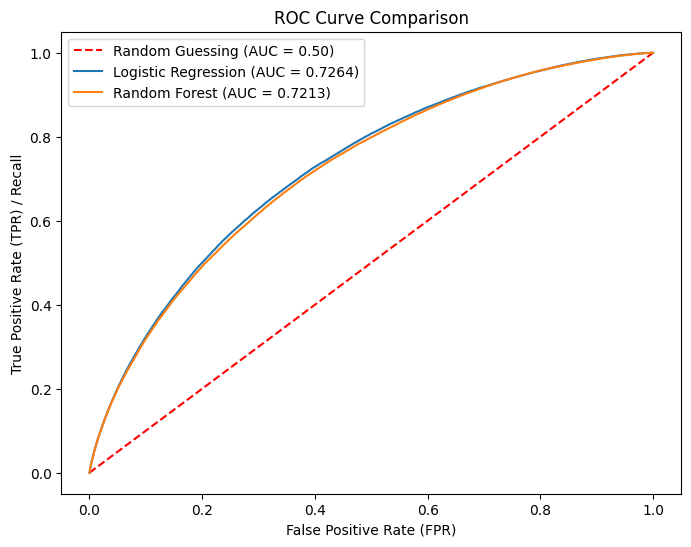

In [46]:
# --- Visualize ROC Curves for Comparison ---
plt.figure(figsize=(8, 6))
plt.title('ROC Curve Comparison')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing (AUC = 0.50)')

for name, result in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, result['Proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["ROC_AUC"]:.4f})')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.legend()
plt.show()


--- Top 15 Feature Importances (from Random Forest) ---
int_rate                0.227318
term_ 60 months         0.128067
fico_range_low          0.040963
grade_B                 0.036537
fico_range_high         0.036478
grade_D                 0.035943
loan_age_months         0.035321
grade_E                 0.031990
dti                     0.028544
acc_open_past_24mths    0.019926
grade_C                 0.019773
tot_hi_cred_lim         0.019320
loan_amnt               0.016955
avg_cur_bal             0.016655
all_util                0.015942


C:\Users\trias\AppData\Local\Temp\ipykernel_4348\3349049585.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15.values, y=top_15.index, palette="viridis")


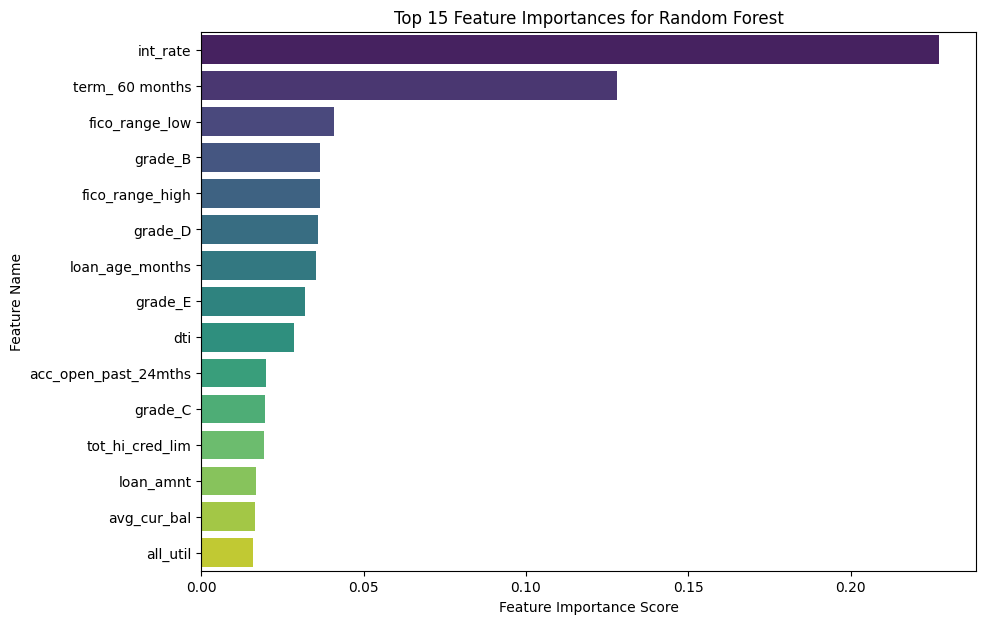

In [47]:
# --- Feature Importance (Only for Random Forest as it provides a direct ranking) ---
if 'Random Forest' in model_results:
    print("\n--- Top 15 Feature Importances (from Random Forest) ---")
    
    importances = rf_clf.feature_importances_
    feature_names = X_train_scaled.columns
    
    # Create a Series for easy sorting
    feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    # Print and plot top 15
    top_15 = feature_importance_series.head(15)
    print(top_15.to_string())
    
    plt.figure(figsize=(10, 7))
    sns.barplot(x=top_15.values, y=top_15.index, palette="viridis")
    plt.title('Top 15 Feature Importances for Random Forest')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature Name')
    plt.show()

In [51]:
print(f"Data Loaded: X_train shape {X_train_scaled.shape}, X_test shape {X_test_scaled.shape}")

Data Loaded: X_train shape (961740, 196), X_test shape (412175, 196)


In [52]:
print("\n--- Training Model 3: XGBoost Classifier ---")



--- Training Model 3: XGBoost Classifier ---


In [54]:
# A. Calculate scale_pos_weight for Imbalance Handling
non_default_count = y_train.value_counts()[0]
default_count = y_train.value_counts()[1]
scale_pos_weight = non_default_count / default_count

print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")


Calculated scale_pos_weight: 3.65


In [60]:
problem_chars = r'[\[\]<,]+'
    
X_train_scaled.columns = X_train_scaled.columns.str.replace(problem_chars, '_', regex=True)
X_test_scaled.columns = X_test_scaled.columns.str.replace(problem_chars, '_', regex=True)


In [62]:
# B. Initialize and Train XGBoost
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight, # Imbalance handling
    max_depth=5, # Reduced depth for speed and preventing overfitting
    n_jobs=-1
)

xgb_clf.fit(X_train_scaled, y_train)

# Evaluation
evaluate_model(xgb_clf, X_test_scaled, y_test, 'XGBoost')



Evaluating XGBoost...
ROC AUC Score: 0.7389

Classification Report:
              precision    recall  f1-score   support

           0     0.8846    0.6647    0.7590    323622
           1     0.3580    0.6832    0.4698     88553

    accuracy                         0.6687    412175
   macro avg     0.6213    0.6740    0.6144    412175
weighted avg     0.7715    0.6687    0.6969    412175



In [63]:
# --- STEP 6: FINAL COMPARISON ---

print("\n--- Final Summary of All Model Performance ---")


--- Final Summary of All Model Performance ---



Best Model by ROC AUC: XGBoost (Score: 0.7389)
Comparing the three models to establish the strongest baseline.


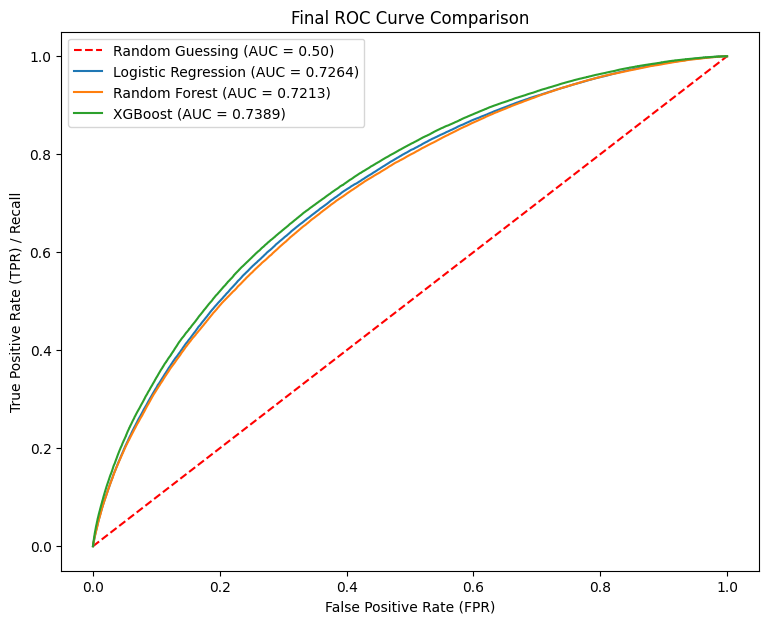

In [64]:
# Update best model identification to include XGBoost
best_model = max(model_results, key=lambda k: model_results[k]['ROC_AUC'])

print(f"\nBest Model by ROC AUC: {best_model} (Score: {model_results[best_model]['ROC_AUC']:.4f})")
print("Comparing the three models to establish the strongest baseline.")

# --- Re-Visualize ROC Curves for Final Comparison (including XGBoost) ---
plt.figure(figsize=(9, 7))
plt.title('Final ROC Curve Comparison')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing (AUC = 0.50)')

for name, result in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, result['Proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["ROC_AUC"]:.4f})')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.legend()
plt.show()


--- Top 15 Feature Importances (from XGBoost) ---
int_rate                   0.162107
grade_B                    0.117998
term_ 60 months            0.046289
grade_C                    0.040573
emp_length_MISSING         0.033262
home_ownership_MORTGAGE    0.023241
loan_age_months            0.019949
home_ownership_RENT        0.018562
acc_open_past_24mths       0.016071
mort_acc                   0.014558
avg_cur_bal                0.013251
num_actv_rev_tl            0.012683
fico_range_low             0.012374
addr_state_CO              0.011454
addr_state_WA              0.010518


C:\Users\trias\AppData\Local\Temp\ipykernel_4348\363080962.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15_xgb.values, y=top_15_xgb.index, palette="mako")


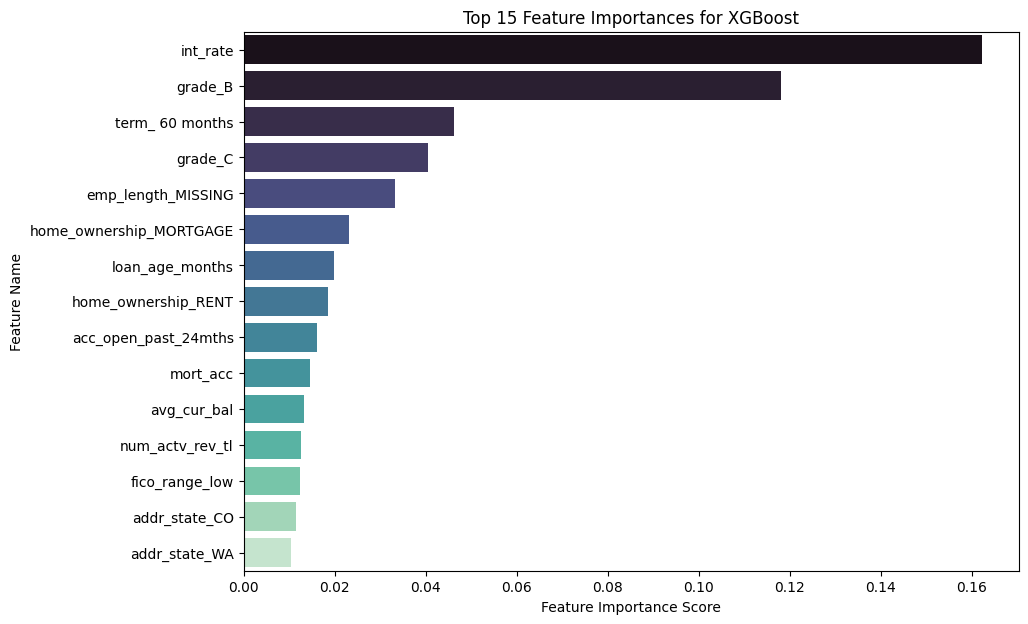

In [65]:
# --- XGBoost Feature Importance ---
if 'XGBoost' in model_results:
    print("\n--- Top 15 Feature Importances (from XGBoost) ---")
    
    importances = xgb_clf.feature_importances_
    feature_names = X_train_scaled.columns
    
    feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    top_15_xgb = feature_importance_series.head(15)
    print(top_15_xgb.to_string())
    
    plt.figure(figsize=(10, 7))
    sns.barplot(x=top_15_xgb.values, y=top_15_xgb.index, palette="mako")
    plt.title('Top 15 Feature Importances for XGBoost')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature Name')
    plt.show()
